# 🛣️ Análisis y Visualización de la Red Vial en Suba, Bogotá

Este script realiza un análisis y visualización de la red de vías en la localidad de **Suba, Bogotá, Colombia**, utilizando la librería [OSMnx](https://github.com/gboeing/osmnx). El cual tiene como objetivo obtener, procesar analizar y visualizar la red vial de Suba incluyendo un área de influencia, para generar un analisis de rutas optimas entre dos puntos.

--- 
Enlace GitHub: [Network-Analysis](https://github.com/RicardoMartinezS/Network-Analysis)

## 0. Importar librerias



In [47]:
import osmnx as ox
import math
import myst_nb
import contextily
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry
from collections import Counter


# 1. Descarga de información


1. **Descarga del grafo inicial**
   - Se obtiene la red de vías transitables por vehículos (`network_type="drive"`) para la zona de Suba.

2. **Generación y reproyección del polígono**
   - Se extrae la geometría de Suba como polígono.
   - Se reproyecta a un sistema métrico (`EPSG:3067`) para aplicar un **buffer de 200 metros**.
   - Luego, se transforma nuevamente a coordenadas geográficas (`EPSG:4326`) para su uso con OpenStreetMap.

3. **Descarga del grafo con mayor detalle**
   - Utilizando el polígono buffered, se descarga una red vial más completa (`network_type="all"`) que incluye todo tipo de vías (peatonales, ciclovías, etc.).

4. **Visualización sin nodos**
   - Se genera una figura de la red vial **sin mostrar nodos**, con personalización en el estilo visual (color gris, líneas delgadas y semi-transparentes).

5. **Exportación de la imagen**
   - Se guarda la visualización como imagen `.png` en alta resolución (`vias_sin_nodos_suba.png`).

6. **Visualización con nodos**
   - Finalmente, se muestra el grafo (posiblemente con nodos, aunque sin configuración explícita diferenciada).



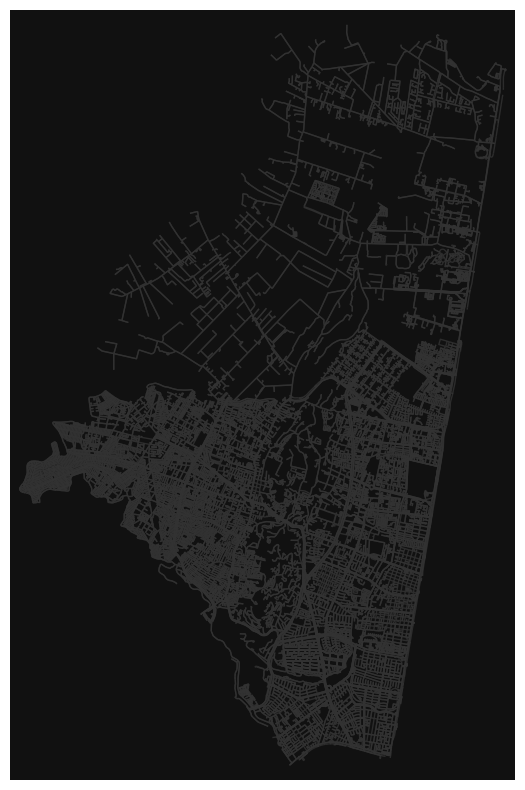

C:\Users\ricar\AppData\Local\Temp\ipykernel_19576\3136970047.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [2]:
#Busqueda de vías en Suba, Bogotá, Colombia

PLACE_NAME = "Suba, Bogotá, Colombia"
graph_initial = ox.graph_from_place(PLACE_NAME, network_type="drive")

#Reproyecta el grafo a un sistema de coordenadas

place_polygon = ox.geocode_to_gdf(PLACE_NAME)
place_polygon = place_polygon.to_crs("EPSG:3067")
place_polygon["geometry"] = place_polygon.buffer(200)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Crea un grafo de vías a partir del polígono con un buffer de 200 metros

graph = ox.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="all"
)

# Visualiza el grafo de vías sin nodos
fig, ax = ox.plot_graph(
    graph,
    node_size=0,               # oculta nodos
    edge_color="#333333",      # color gris oscuro
    edge_linewidth=1.0,        # grosor de las vías
    edge_alpha=0.8,            # ligera transparencia para suavizar el visual
    figsize=(10, 10),          # tamaño de figura

)

# Guarda la figura del grafo de vías sin nodos
fig.savefig("vias_sin_nodos_suba.png", dpi=300, bbox_inches="tight")

# Visualiza el grafo de vías con nodos
fig.show()


In [3]:
# Almacena unicamente los nodos del grafo
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  highway  oneway reversed      length  \
u         v           key                                                     
255476400 4913735031  0     645873850  footway   False    False    8.146538   
          381991485   0    1195009265  primary    True    False   11.921676   
          11774394549 0     645873850  footway   False     True   12.706621   
259665451 5718775594  0     809284675    trunk    True    False  745.334231   
          273536445   0    1153629523    trunk    True    False  110.133567   

                          lanes                name  \
u         v           key                             
255476400 4913735031  0     NaN                 NaN   
          381991485   0       3      Transversal 60   
          11774394549 0     NaN                 NaN   
259665451 5718775594  0       3  Avenida Carrera 45   
          273536445   0       2  Avenida Carrera 45   

                                                                    geometry  \
u         v           key                                                      
255476400 4913735031  0    LINESTRING (-74.07226 4.71122, -74.07219 4.71124)   
          381991485   0    LINESTRING (-74.07226 4.71122, -74.07224 4.71112)   
          11774394549 0    LINESTRING (-74.07226 4.71122, -74.07231 4.711...   
259665451 5718775594  0    LINESTRING (-74.04663 4.75285, -74.04657 4.752...   
          273536445   0    LINESTRING (-74.04663 4.75285, -74.04663 4.752...   

                          maxspeed  ref service access bridge junction width  \
u         v           key                                                      
255476400 4913735031  0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          381991485   0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          11774394549 0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
259665451 5718775594  0         50  NaN     NaN    NaN    NaN      NaN   NaN   
          273536445   0         60  NaN     NaN    NaN    NaN      NaN   NaN   

                          area tunnel  
u         v           key              
255476400 4913735031  0    NaN    NaN  
          381991485   0    NaN    NaN  
          11774394549 0    NaN    NaN  
259665451 5718775594  0    NaN    NaN  
          273536445   0    NaN    NaN

In [4]:
# Cuenta la cantidad de vías por tipo de carretera
edges["highway"].value_counts()

highway
residential                         20584
footway                             19040
service                             14758
tertiary                             3934
cycleway                             2376
secondary                            1483
primary                              1048
[residential, footway]                566
trunk                                 446
path                                  344
[service, footway]                    178
unclassified                          156
primary_link                          149
corridor                              124
trunk_link                            117
[corridor, footway]                    94
pedestrian                             93
steps                                  84
[steps, footway]                       80
[residential, service]                 70
track                                  48
[cycleway, footway]                    22
[residential, steps]                   18
secondary_link            

In [5]:
# Reproyecta el grafo a un sistema de coordenadas 
graph = ox.project_graph(graph) 

# Extrae los nodos reproyectados
nodes, edges = ox.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## 2. Análisis de las propiedades de la red

Ahora que se tiene una red apto para el _routing_, se procede a realizar funciones analíticas que ofrece OSMnx y extraer información relevante sobre la red. Para calcular estas caracteristicas se puede utilizar la función osmnx.basic_stats()

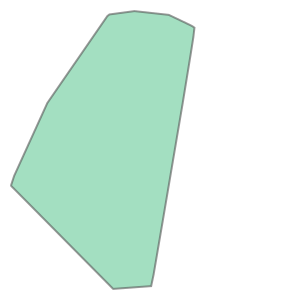

In [6]:
#Genera un polígono convex a partir de las vías del grafo
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [7]:
stats = ox.basic_stats(graph, area=convex_hull.area)
stats

{'n': 25254,
 'm': 65882,
 'k_avg': 5.217549695097806,
 'edge_length_total': 3468065.8048665356,
 'edge_length_avg': 52.640566541187816,
 'streets_per_node_avg': 2.8508751088936406,
 'streets_per_node_counts': {0: 0,
  1: 4659,
  2: 39,
  3: 15048,
  4: 5434,
  5: 65,
  6: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1844856260394393,
  2: 0.0015443098123069613,
  3: 0.5958660014255167,
  4: 0.21517383384810326,
  5: 0.0025738496871782687,
  6: 0.0003563791874554526},
 'intersection_count': 20595,
 'street_length_total': 1915511.9232545989,
 'street_segment_count': 35925,
 'street_length_avg': 53.319747341812075,
 'circuity_avg': 1.06428114342133,
 'self_loop_proportion': 0.003312456506610995,
 'node_density_km': 227.96386175104135,
 'intersection_density_km': 185.9078060015323,
 'edge_density_km': 31305.681226107106,
 'street_density_km': 17291.023016365038}

### 📊 Estadísticas Básicas de la Red Vial en Suba, Bogotá

Utilizando la función `ox.basic_stats()` de la librería OSMnx, se calcularon una serie de métricas que describen cuantitativamente la estructura de la red vial obtenida para Suba, Bogotá. A continuación se explican cada uno de los indicadores generados:

#### 🔢 Estructura del Grafo

- **`n` (nodos):** `25,254`    Número total de nodos (intersecciones y puntos finales) en la red.

- **`m` (aristas):** `65,882`  Número total de aristas (segmentos de vía) en el grafo.

- **`k_avg` (grado promedio):** `5.22`  Promedio de conexiones (aristas) por nodo, útil para entender la conectividad general.


#### 🛣️ Longitudes de las Vías

- **`edge_length_total`:** `3,468,065.80 m`  Longitud total de todas las aristas (vías) en metros.

- **`edge_length_avg`:** `52.64 m`  Longitud promedio por segmento de vía.


#### 🔗 Intersecciones y Conectividad

- **`streets_per_node_avg`:** `2.85`  Promedio de calles que se conectan por nodo.
- **`intersection_count`:** `20,595`   Número total de intersecciones en la red.

<div style="display: flex; justify-content: center; gap: 40px;">

  <table>
    <caption><strong>streets_per_node_counts</strong></caption>
    <tr><th>Número de calles</th><th>Cantidad de nodos</th></tr>
    <tr><td>1</td><td>4,659</td></tr>
    <tr><td>2</td><td>39</td></tr>
    <tr><td>3</td><td>15,048</td></tr>
    <tr><td>4</td><td>5,434</td></tr>
    <tr><td>5</td><td>65</td></tr>
    <tr><td>6</td><td>9</td></tr>
  </table>

  <table>
    <caption><strong>streets_per_node_proportions</strong></caption>
    <tr><th>Número de calles</th><th>Proporción (%)</th></tr>
    <tr><td>1</td><td>18.45%</td></tr>
    <tr><td>2</td><td>0.15%</td></tr>
    <tr><td>3</td><td>59.59%</td></tr>
    <tr><td>4</td><td>21.52%</td></tr>
    <tr><td>5</td><td>0.26%</td></tr>
    <tr><td>6</td><td>0.04%</td></tr>
  </table>

</div>


#### 🧱 Segmentos y Densidad

- **`street_segment_count`:** `35,925` Número total de segmentos de calle únicos (no dirigidos).

- **`street_length_total`:** `1,915,511.92 m`  Longitud total de calles sin considerar la dirección.

- **`street_length_avg`:** `53.32 m`   Longitud promedio por segmento de calle.


#### 📏 Densidades Espaciales (por km²)

- **`node_density_km`:** `227.96 nodos/km²`  
- **`intersection_density_km`:** `185.91 intersecciones/km²`  
- **`edge_density_km`:** `31,305.68 m de vías/km²`  
- **`street_density_km`:** `17,291.02 m de calles/km²`  


In [8]:
myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

228.0

3468

# 3. Visualización de Red Vial y Categorías de `highway` Más Frecuentes

Se visualiza el grafo de la red vial junto a un gráfico de barras que presenta las **5 categorías más frecuentes** del atributo `highway`, utilizando los **mismos colores** en ambas visualizaciones para mantener la coherencia visual.


## 🔧 Pasos principales

### 3.1. 📥 Extraer las categorías `highway`
Se recorren todas las aristas del grafo y se recopilan los valores del atributo `highway`, que representa el tipo de vía (por ejemplo: `residential`, `primary`, `secondary`, etc.).

### 3.2. 📊 Contar las categorías más frecuentes
Se contabiliza la frecuencia de cada tipo de `highway` y se seleccionan las **5 categorías más comunes**.

### 3.3. 🎨 Asignar colores a cada categoría
A cada una de las 5 categorías seleccionadas se le asigna un color específico que se usará tanto en el grafo como en el gráfico de barras.

### 3.4. 🗺️ Graficar el grafo
Se visualiza la red vial usando OSMnx, donde las **aristas (vías)** se colorean según su categoría `highway`.

### 3.5. 📈 Graficar el gráfico de barras
Se crea un gráfico de barras para mostrar las frecuencias de las 5 categorías principales, utilizando los **mismos colores** definidos en la visualización de la red.



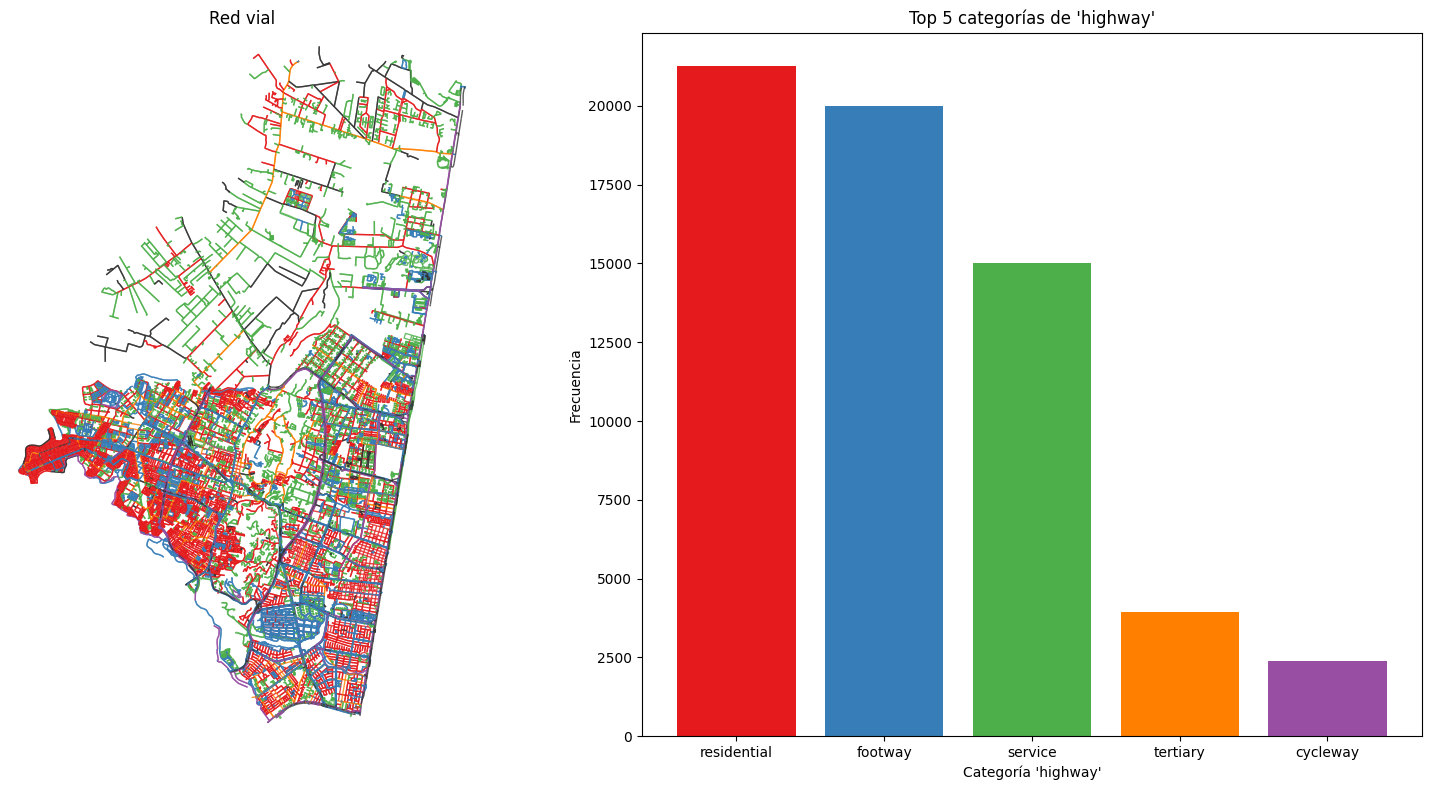

In [9]:

# Extraer el atributo 'highway' de las aristas
highways = []
for u, v, k, data in graph.edges(keys=True, data=True):
    hw = data.get('highway')
    if isinstance(hw, list):
        highways.extend(hw)
    elif hw:
        highways.append(hw)

# Contar las 5 categorías más frecuentes
counter = Counter(highways)
top5 = counter.most_common(5)
categories, counts = zip(*top5)

# Asignar colores a las categorías (puedes personalizar estos colores)
color_map = {
    categories[0]: "#e41a1c",
    categories[1]: "#377eb8",
    categories[2]: "#4daf4a",
    categories[3]: "#ff7f00",
    categories[4]: "#984ea3",
}

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Graficar el grafo, coloreando las aristas según la categoría
edge_colors = []
for u, v, k, data in graph.edges(keys=True, data=True):
    hw = data.get('highway')
    if isinstance(hw, list):
        hw = hw[0]
    color = color_map.get(hw, "#333333")
    edge_colors.append(color)

ox.plot_graph(
    graph,
    ax=ax1,
    node_size=0,
    edge_color=edge_colors,
    edge_linewidth=1.0,
    edge_alpha=0.8,
    show=False,
    close=False
)

ax1.set_title("Red vial")

# Graficar barras
bars = ax2.bar(categories, counts, color=[color_map[c] for c in categories])
ax2.set_title("Top 5 categorías de 'highway'")
ax2.set_ylabel("Frecuencia")
ax2.set_xlabel("Categoría 'highway'")

plt.tight_layout()
plt.show()

## 4. Diseño de rutas óptimas

Una **ruta óptima** es el camino más eficiente entre un punto de origen y un destino dentro de una red vial, según un criterio específico, como la distancia más corta, el menor tiempo de viaje o el menor costo. En el contexto de redes viales, encontrar rutas óptimas es fundamental para la planificación urbana, la logística y la movilidad eficiente.

Para calcular rutas óptimas en grafos, se utilizan algoritmos clásicos como:

- **Dijkstra:** Encuentra el camino más corto entre dos nodos considerando el peso de las aristas (por ejemplo, la longitud de las vías). Es eficiente y garantiza encontrar la ruta óptima en grafos con pesos no negativos.
- **A\* (A estrella):** Es una extensión de Dijkstra que utiliza una heurística (como la distancia euclidiana al destino) para acelerar la búsqueda, priorizando los caminos que parecen más prometedores. Es especialmente útil en redes grandes y cuando se busca eficiencia computacional.

Ambos algoritmos son ampliamente utilizados en sistemas de navegación y análisis de redes

In [ ]:
#Selecciona un origen y un destino para calcular la ruta más corta

origin = (
    ox.geocode_to_gdf("Portal suba, bogota")  
    .to_crs(edges.crs)  
    .at[0, "geometry"]  
    .centroid  
)

destination = (
    ox.geocode_to_gdf("Clinica la colina, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [24]:
origin_node_id = ox.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph, destination.x, destination.y)

## Comparar los algoritmos

In [27]:
# Ruta con Dijkstra
route_dijkstra = nx.shortest_path(graph, origin_node_id, destination_node_id, weight="length", method="dijkstra")

In [ ]:
# Ruta con A*
route_astar = nx.astar_path(graph, origin_node_id, destination_node_id, weight="length")

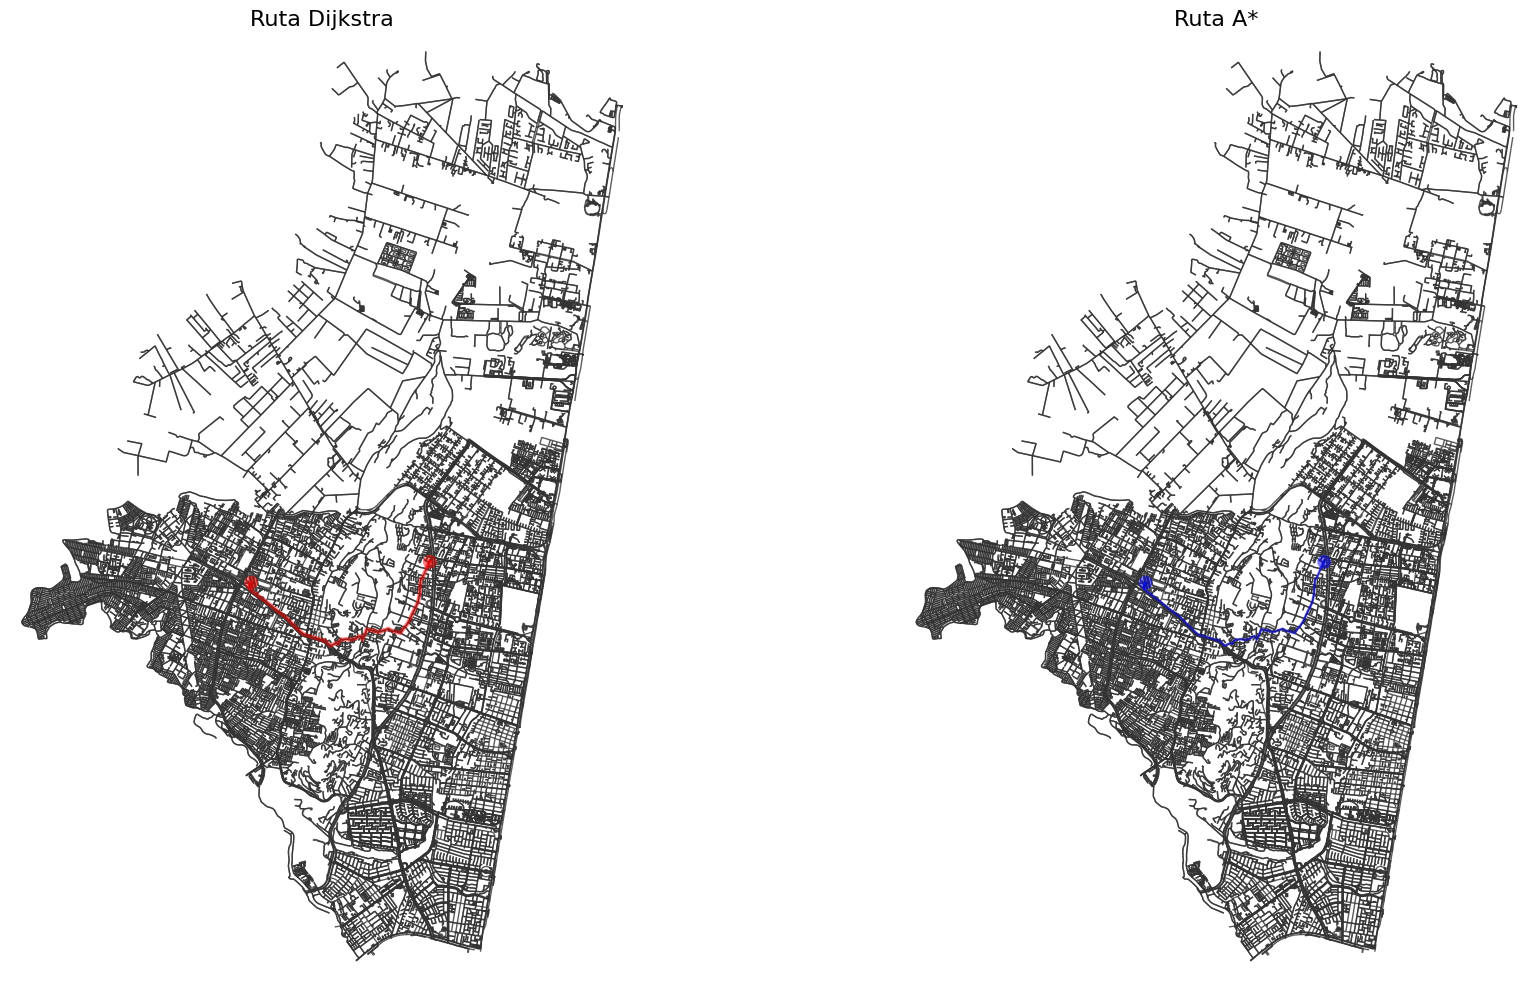

In [25]:
# Crea una figura con 2 paneles uno al lado del otro
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10))

# Primer gráfico: ruta Dijkstra
ox.plot_graph(graph, ax=ax1, node_size=0, edge_color="#333333",
              edge_linewidth=1.0, edge_alpha=0.8, show=False, close=False)
ox.plot_graph_route(graph, route_dijkstra,
                    ax=ax1, route_color='red', route_linewidth=3,
                    orig_dest_node_color='green', show=False, close=False)
ax1.set_title('Ruta Dijkstra', fontsize=16)

# Segundo gráfico: ruta A* (o ASTAR)
ox.plot_graph(graph, ax=ax2, node_size=0, edge_color="#333333",
              edge_linewidth=1.0, edge_alpha=0.8, show=False, close=False)
ox.plot_graph_route(graph, route_astar,
                    ax=ax2, route_color='blue', route_linewidth=2,
                    orig_dest_node_color='orange', show=False, close=False)
ax2.set_title('Ruta A*', fontsize=16)

# Ajusta layout y muestra
plt.tight_layout()
plt.show()

In [ ]:
#Análisis de las rutas generadas por Dijkstra y A*
diferentes = [x for x in route_dijkstra if x not in route_astar] + [x for x in route_astar if x not in route_dijkstra]
print(diferentes)  

[]


### Comparación de Resultados: Dijkstra vs A*

Una vez analizada la lista de resultados, se concluye que **no hay diferencias en las rutas calculadas** para esta red entre los algoritmos de Dijkstra y A*. Ambos producen el mismo camino óptimo.

No obstante, en términos computacionales, se observa una **ligera ventaja en el tiempo de ejecución del algoritmo A***, el cual fue aproximadamente un **6% más rápido** que Dijkstra en este caso específico.


# 5. Creación de una ruta óptima excluyendo tipos de vía

En esta sección se calcula una **ruta óptima** entre dos puntos, pero excluyendo ciertos tipos de vías de la red vial. Este enfoque es útil cuando se desea evitar calles residenciales, peatonales o cualquier otro tipo de vía que no sea adecuada para el análisis o el propósito del trayecto.

El procedimiento consiste en:

1. **Filtrar las aristas del grafo** para eliminar aquellas cuyo atributo `highway` corresponde a tipos de vía no deseados (por ejemplo, `residential` o `footway`).
2. **Crear un subgrafo** que solo contenga las vías permitidas.
3. **Buscar los nodos de origen y destino** más cercanos dentro del subgrafo filtrado.
4. **Calcular la ruta óptima** usando el algoritmo de Dijkstra, garantizando que el trayecto solo utilice los tipos de vía seleccionados.
5. **Visualizar la ruta resultante** sobre la red vial filtrada.

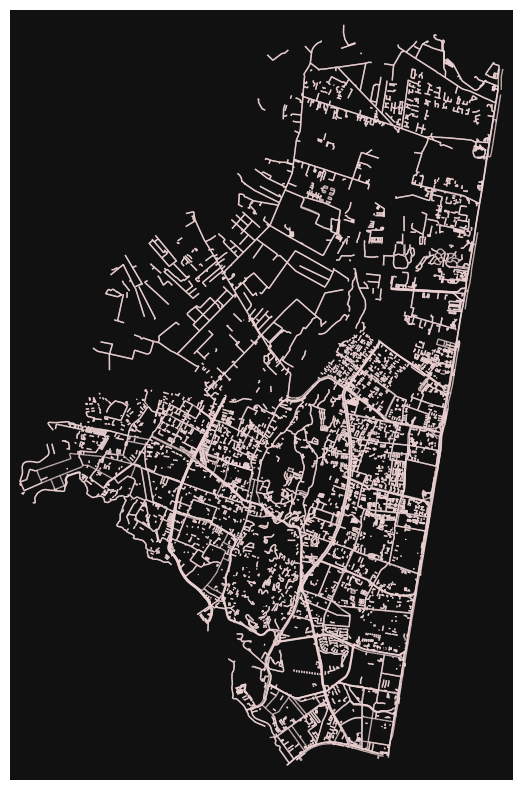

C:\Users\ricar\AppData\Local\Temp\ipykernel_19576\135255397.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [59]:
# Extrae las aristas del grafo y filtra por tipo de vía
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

edges_selected = edges[~edges['highway'].isin(['residential', 'footway'])]

edges_selected = nx.edge_subgraph(graph, edges_selected.index).copy()

fig, ax = ox.plot_graph(
    edges_selected,
    node_size=0,               # oculta nodos
    edge_color="#EDD3D3",      # color gris oscuro
    edge_linewidth=1.0,        # grosor de las vías
    edge_alpha=0.8,            # ligera transparencia para suavizar el visual
    figsize=(10, 10),          # tamaño de figura

)

fig.savefig("vias_sin_nodos_seleccion_tipo_via.png", dpi=300, bbox_inches="tight")

fig.show()

In [44]:
# Asegúrate de que 'u', 'v', 'key' sean columnas (no índice)
edges_selected = edges_selected.reset_index()

# Asegúrate de que 'u', 'v', 'key' sean valores simples, no listas
for col in ['u', 'v', 'key']:
    edges_selected[col] = edges_selected[col].apply(lambda x: x[0] if isinstance(x, list) else x)

# Crear lista de tuplas (u, v, key) para el subgrafo
edge_tuples = list(edges_selected[['u', 'v', 'key']].itertuples(index=False, name=None))

# Crear subgrafo solo con esos edges
graph_selected = nx.edge_subgraph(graph, edge_tuples).copy()

# Obtener nodos del subgrafo
nodes_selected = list(graph_selected.nodes)

# Buscar el nodo más cercano en el subgrafo filtrado
origin_node_id = ox.nearest_nodes(graph_selected, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph_selected, destination.x, destination.y)

# Verificar si ambos nodos están en el mismo componente conexo
if nx.has_path(graph_selected, origin_node_id, destination_node_id):
    # Calcular la ruta en el subgrafo filtrado
    route_dijkstra2 = nx.shortest_path(graph_selected, origin_node_id, destination_node_id, weight="length", method="dijkstra")
    # Graficar la ruta sobre el subgrafo filtrado
    fig, ax = ox.plot_graph(graph_selected, show=False, close=False)
    ox.plot_graph_route(graph_selected, route_dijkstra2, route_color='blue', ax=ax, route_linewidth=2, orig_dest_node_color='orange', show=True, close=True)
else:
    print("No existe un camino entre origen y destino en el subgrafo filtrado.")

No existe un camino entre origen y destino en el subgrafo filtrado.


# 6. Análisis de construcciones cercanas en la ruta óptima

En esta sección se realiza un análisis espacial para identificar y caracterizar las **construcciones (edificios) que se encuentran próximas a la ruta óptima** calculada previamente. Este tipo de análisis es útil para evaluar la accesibilidad, el impacto urbano y la relación entre la infraestructura vial y el entorno construido.

El procedimiento consiste en:

1. **Crear un buffer alrededor de la ruta óptima** (por ejemplo, de 50 metros) para definir el área de influencia directa de la vía.
2. **Seleccionar los edificios que intersectan este buffer**, es decir, aquellos que se encuentran dentro de la zona de influencia de la ruta.
3. **Contar y clasificar los edificios encontrados** según su tipo o función, utilizando el atributo `building` de OpenStreetMap.
4. **Visualizar los resultados** sobre el mapa, resaltando tanto la ruta como los edificios dentro del buffer.
5. **Exportar los datos** de los edificios seleccionados para su análisis posterior o uso en otros sistemas.


In [45]:
route_nodes = nodes.loc[route_dijkstra]
route_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
12844382887,524737.349094,600417.771867,NaN,3,POINT (600417.772 524737.349)
12844382885,524719.868443,600424.349499,NaN,4,POINT (600424.349 524719.868)
9851261791,524712.466983,600394.735165,NaN,3,POINT (600394.735 524712.467)
12844382876,524693.734141,600399.051869,NaN,3,POINT (600399.052 524693.734)
9851261793,524660.135954,600389.391182,NaN,3,POINT (600389.391 524660.136)
...,...,...,...,...,...
9735691684,525083.037632,603606.163311,crossing,3,POINT (603606.163 525083.038)
9735691683,525091.897839,603609.833565,NaN,3,POINT (603609.834 525091.898)
9735691681,525099.917370,603613.150041,NaN,3,POINT (603613.15 525099.917)


In [60]:
# Obtener las geometrías de los nodos de la ruta
route_nodes = nodes.loc[route_dijkstra]
route_line = shapely.geometry.LineString(route_nodes.geometry.values)

In [61]:
route_geom = gpd.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route_dijkstra],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (600417.772 524737.349, 600424.349 ...","[12844382887, 12844382885, 9851261791, 1284438...",4892.296872


In [62]:
buildings = ox.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

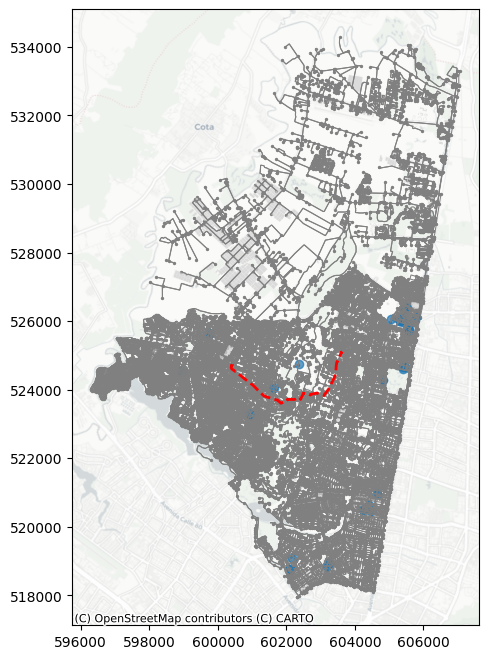

In [63]:
fig, ax = plt.subplots(figsize=(12,8))  # <-- aquí está el cambio

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [64]:
# 1. Crear un buffer de 50 m alrededor de la ruta
buffer_50m = route_geom.geometry.buffer(50).iloc[0]

# 2. Seleccionar edificios que intersectan el buffer
buildings_along_route = buildings[buildings.intersects(buffer_50m)]

# 3. Contar edificios totales y por tipo
total_buildings = buildings_along_route.shape[0]
buildings_by_tag = buildings_along_route['building'].value_counts()

print(f"Total de edificios en el corredor: {total_buildings}")
print("Conteo por tipo de edificio:")
print(buildings_by_tag)


Total de edificios en el corredor: 47
Conteo por tipo de edificio:
building
yes            39
apartments      3
roof            3
residential     1
commercial      1
Name: count, dtype: int64


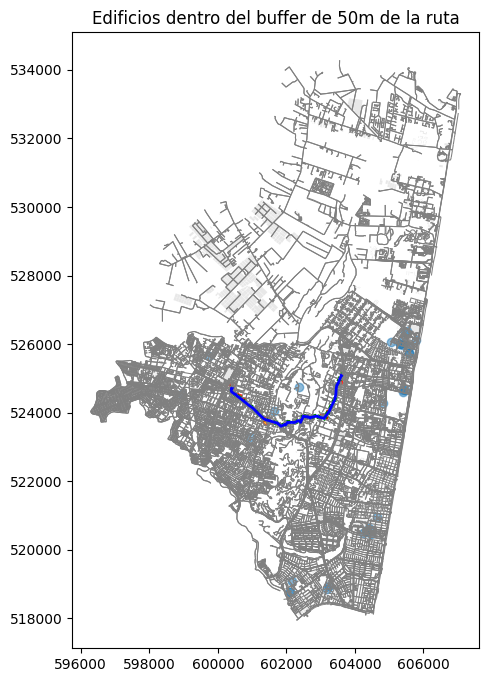

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
edges.plot(ax=ax, linewidth=0.75, color='gray')
buildings.plot(ax=ax, facecolor='lightgray', alpha=0.5)
buildings_along_route.plot(ax=ax, facecolor='orange', edgecolor='red', alpha=0.8)
route_geom.plot(ax=ax, linewidth=2, color='blue')
gpd.GeoSeries(buffer_50m).plot(ax=ax, facecolor='none', edgecolor='green', linestyle='--')
plt.title("Edificios dentro del buffer de 50m de la ruta")
plt.show()

In [66]:
# 4. Exportar a GeoJSON
buildings_along_route.to_file("buildings_along_route.geojson", driver="GeoJSON")